# Filtrado de imágenes digitales II
## Fundamentos de Análisis de Imágenes

- Nombre 1: Ada Moral Merino
- Nombre 2: Lucía Martinez Miramontes
- Nombre 3: Laura García González

## Objetivos

Los objetivos de esta práctica son:
* Repasar algunos conceptos de filtrado de imágenes y programar algunas rutinas para suavizado y extracción de bordes.
* Implementar un algoritmo de extracción de líneas mediante la transformada de Hough.

En esta práctica se usarán varias funciones de filtrado de imágenes disponibles en OpenCV: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html

In [54]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

**Ejercicio 5**: utiliza la funcion [``cv2.bilateralFilter``](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed) de OpenCV para realizar el filtrado bilateral de una imagen. Selecciona los parámetros adecuados y aplícalo a las imágenes ``tapiz.jpg``, ``escgaus.bmp`` y ``escimp5.bmp`` y otras que elijas tú.

Si llamamos $\sigma_r$ a la varianza de de la gaussiana que controla la ponderación debida a la diferencia entre los valores de los píxeles y $\sigma_s$ a la varianza de la gaussiana que controla la ponderación debida a la posición de los píxeles. Responde a la siguientes preguntas:
* ¿Cómo se comporta el filtro bilateral cuando la varianza $\sigma_r$ es muy alta? ¿En este caso qué ocurre si $\sigma_s$ es alta o baja?
* ¿Cómo se comporta si $\sigma_r$ es muy baja? ¿En este caso cómo se comporta el filtro dependiendo si $\sigma_s$ es alta o baja?

Muestra y discute los resultados para distintos valores de los parámetros, tanto para las imágenes contaminadas con ruido gaussiano como impulsivo. Compáralos con los obtenidos en los Ejercicios 1 y 3.

In [55]:
img_tapiz = cv2.cvtColor(cv2.imread('img_pi/tapiz.png'), cv2.COLOR_BGR2RGB)
img_gauss = cv2.imread('img_pi/escgaus.bmp', cv2.IMREAD_GRAYSCALE)
img_imp = cv2.imread('img_pi/escimp5.bmp', cv2.IMREAD_GRAYSCALE)
img_nv = cv2.imread('img_pi/imagen_nueva.jpg')  # carga color por defecto BGR
img_retrato = cv2.cvtColor(img_nv, cv2.COLOR_BGR2RGB)

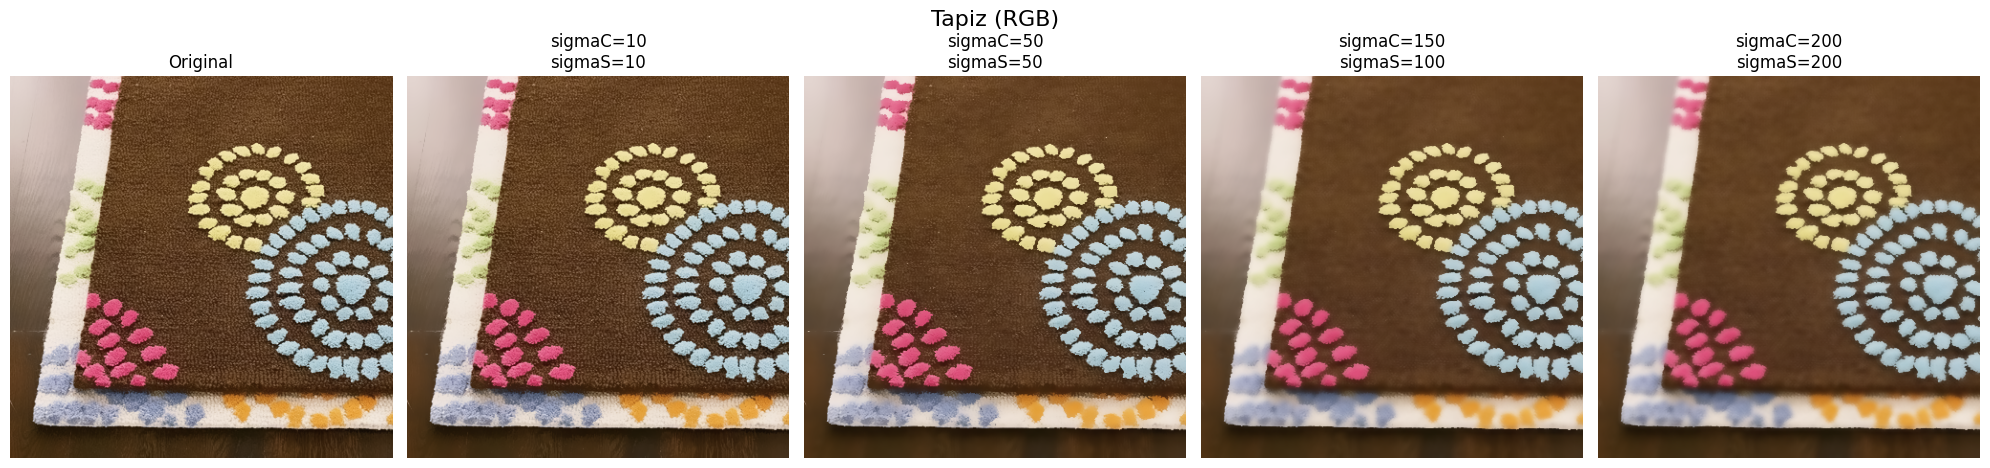

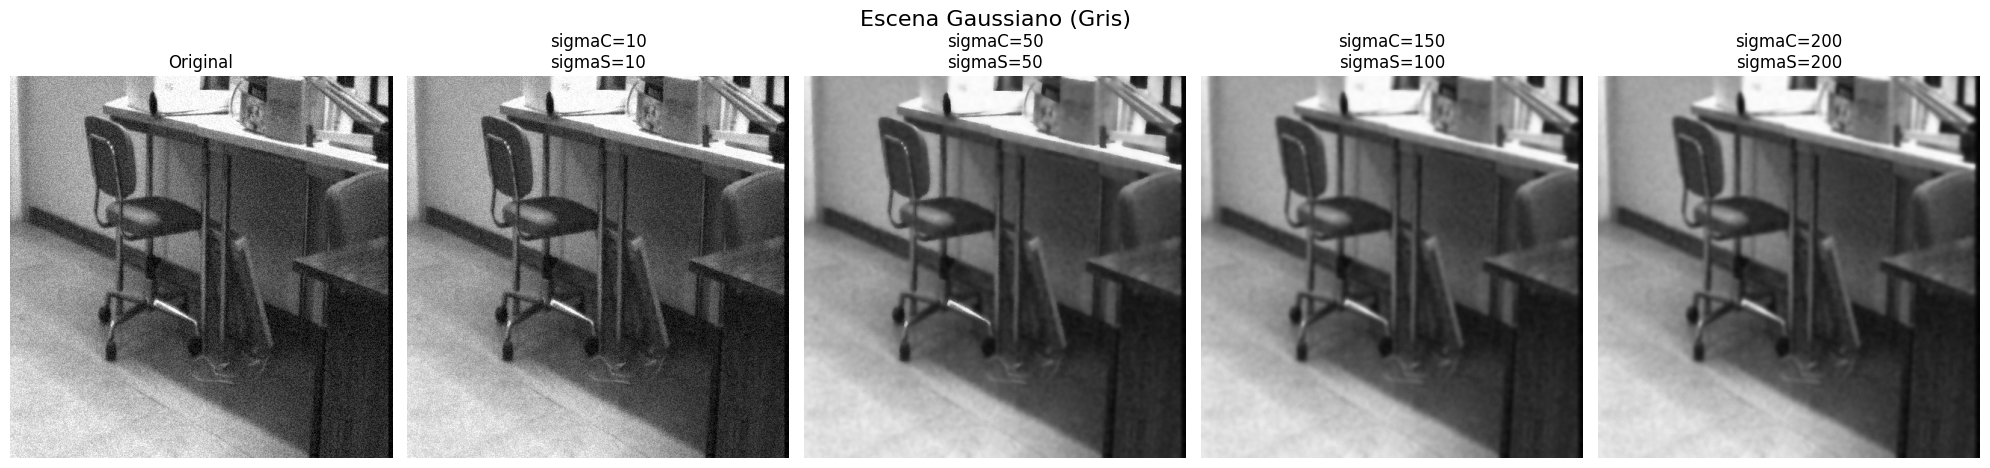

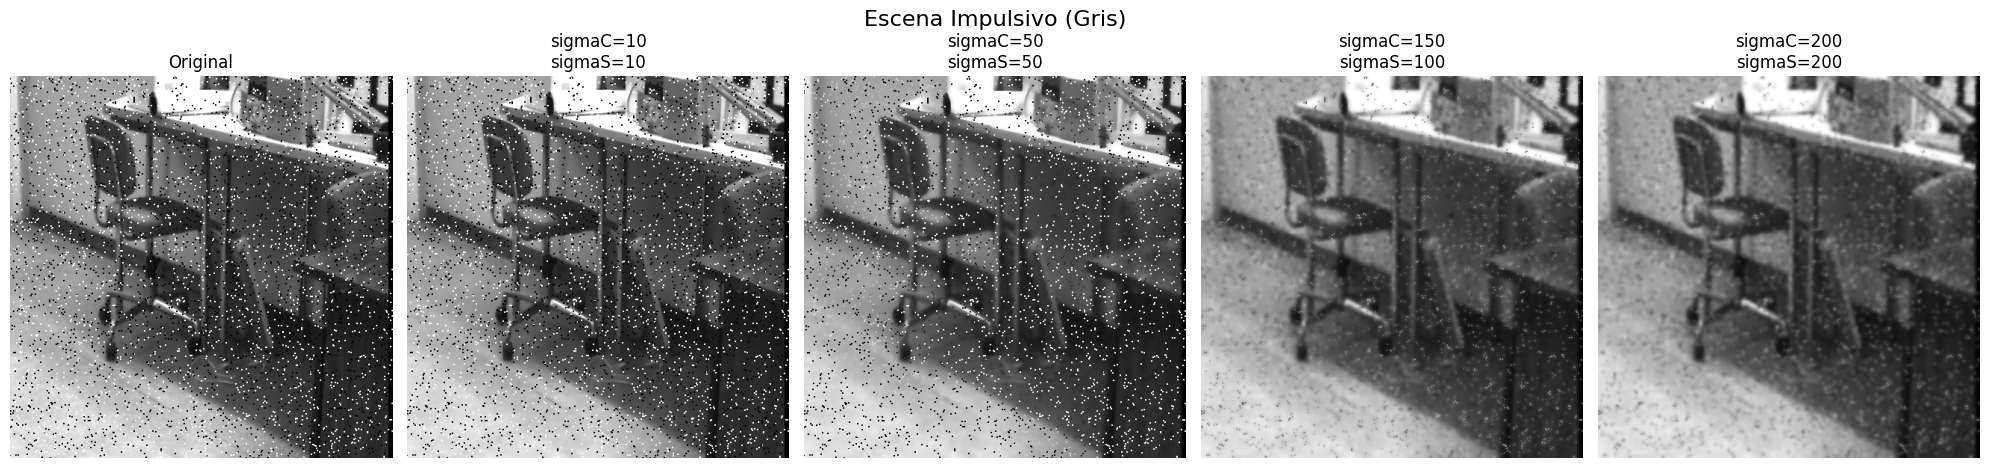

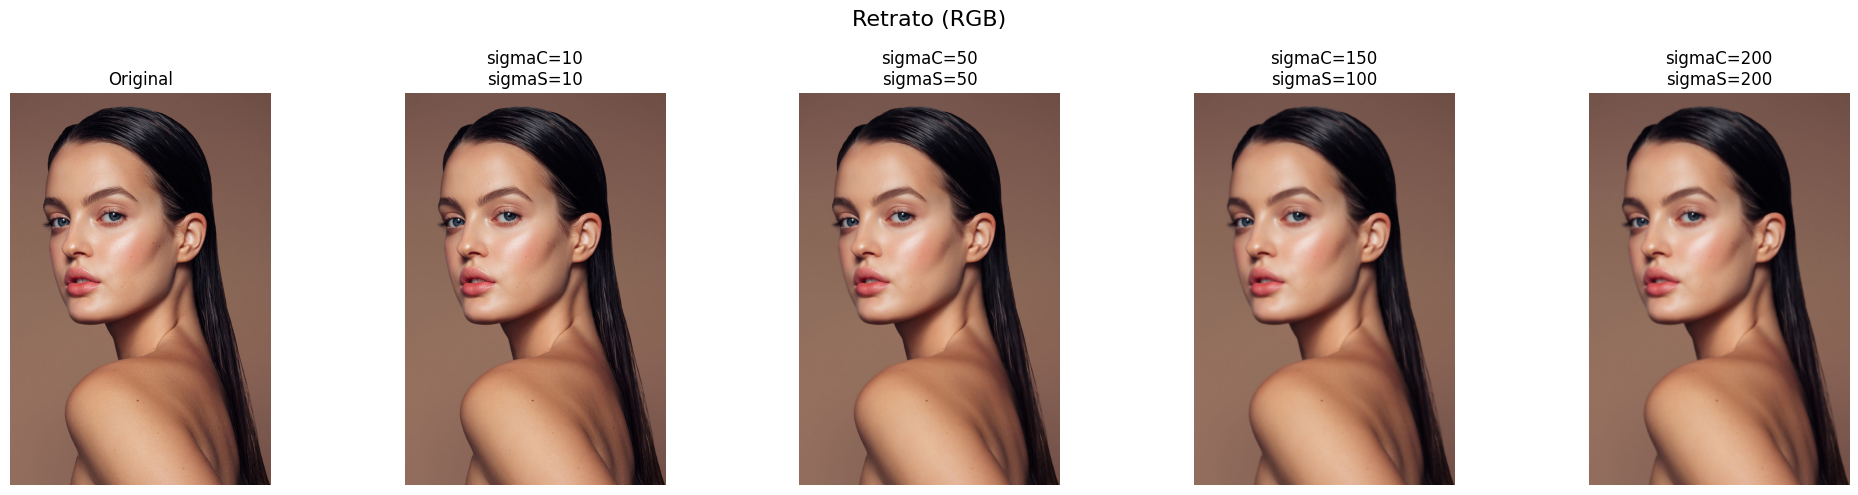

In [56]:

combinaciones = [
    (10, 10),      # casi no suaviza
    (50, 50),      # suavizado moderado
    (150, 100),    # suavizado fuerte, color alto
    (200, 200)     # suavizado muy fuerte, bordes más difusos
]



d = 9  

def mostrar_bilateral(img, titulo, es_color=True):
    fig, axes = plt.subplots(1, 5, figsize=(20,5))
    
    if es_color:
        axes[0].imshow(img)
    else:
        axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    for i, (sigmaC, sigmaS) in enumerate(combinaciones):
        resultado = cv2.bilateralFilter(img, d=d, sigmaColor=sigmaC, sigmaSpace=sigmaS)
        if es_color:
            axes[i+1].imshow(resultado)
        else:
            axes[i+1].imshow(resultado, cmap='gray')
        axes[i+1].set_title(f"sigmaC={sigmaC}\nsigmaS={sigmaS}")
        axes[i+1].axis('off')
    
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()


mostrar_bilateral(img_tapiz, "Tapiz (RGB)", es_color=True)
mostrar_bilateral(img_gauss, "Escena Gaussiano (Gris)", es_color=False)
mostrar_bilateral(img_imp, "Escena Impulsivo (Gris)", es_color=False)
mostrar_bilateral(img_retrato, "Retrato (RGB)", es_color=True)


Como vemos en la imagen escogida por nosotros el filtro bilateral solo suaviza diferencias entre píxeles, y si la imagen no tiene ruido ni variaciones extremas, los píxeles ya son similares, por lo que el resultado prácticamente no cambia visualmente.
Para que el efecto del filtro bilateral se note más, vamos a añadir ruido más intenso a la imagen, en este caso vamos a añadir ruido gaussiano

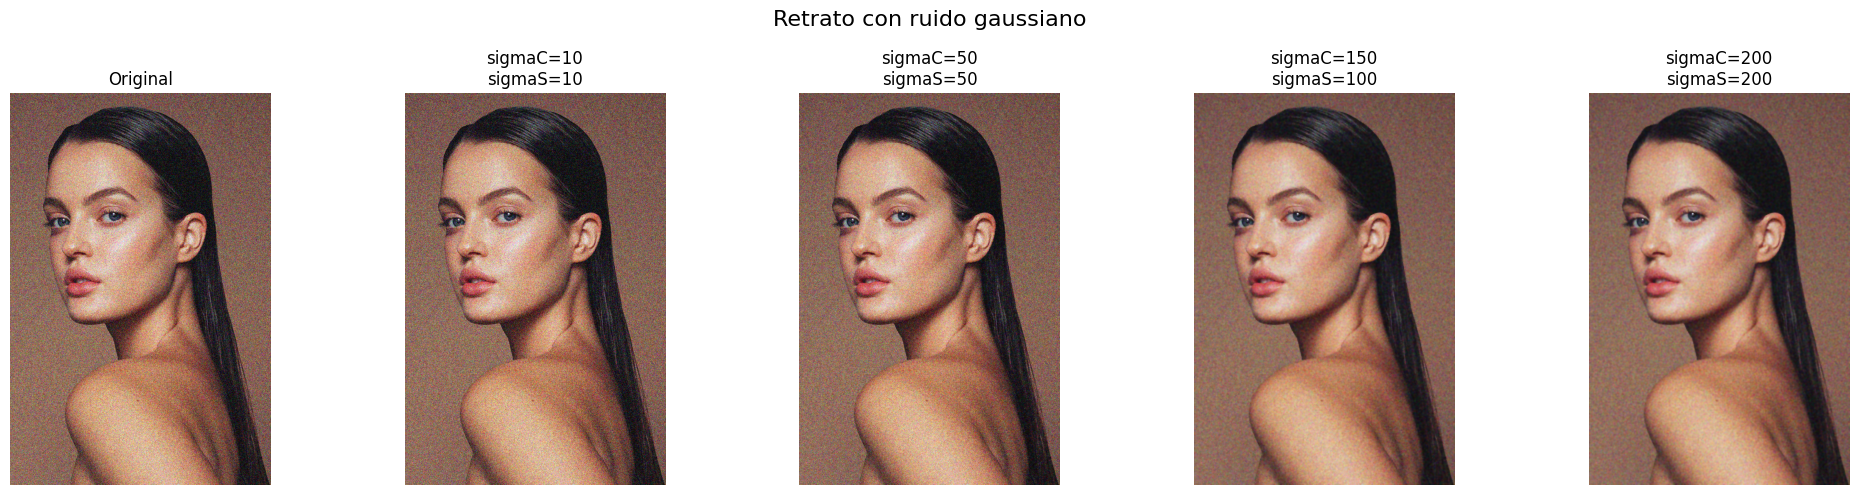

In [ ]:
img_retrato = cv2.cvtColor(img_nv, cv2.COLOR_BGR2RGB) 

sigma_ruido = 50 # intensidad del ruido
ruido = np.random.normal(0, sigma_ruido, img_retrato.shape).astype(np.float32)
img_ruido = np.clip(img_retrato.astype(np.float32) + ruido, 0, 255).astype(np.uint8)

mostrar_bilateral(img_ruido, "Retrato con ruido gaussiano", es_color=True)


* ¿Cómo se comporta el filtro bilateral cuando la varianza $\sigma_r$ es muy alta? ¿En este caso qué ocurre si $\sigma_s$ es alta o baja?

Cuando σ_r es muy alta, la diferencia de intensidad entre los píxeles importa muy poco, por lo que el filtro bilateral se comporta de manera similar a un filtro gaussiano normal: suaviza tanto el ruido como los bordes. Si además σ_s es alta, la suavización se extiende a grandes áreas de la imagen, haciendo que los bordes se vuelvan muy difusos; en cambio, si σ_s es baja, la suavización se limita a un vecindario pequeño, por lo que los bordes se suavizan menos, aunque aún pierden algo de nitidez.

* ¿Cómo se comporta si $\sigma_r$ es muy baja? ¿En este caso cómo se comporta el filtro dependiendo si $\sigma_s$ es alta o baja?

Por otro lado, cuando σ_r es muy baja, el filtro preserva intensamente los bordes, ya que solo promedia píxeles con valores de intensidad muy similares. Si σ_s es alta, la suavización cubre grandes áreas, pero los bordes se mantienen nítidos; mientras que si σ_s es baja, el suavizado se limita a un vecindario pequeño, reduciendo solo el ruido local sin afectar prácticamente los bordes.

Comparando con los ejercicios anteriores, el filtro bilateral combina lo mejor de ambos mundos: a diferencia del Ejercicio 1 (Canny + Hough), reduce el ruido de la imagen antes de la detección de bordes sin difuminarlos, lo que permite que los bordes y líneas detectadas sean más precisos y continuos. Frente al Ejercicio 3 (derivada del gaussiano), el bilateral suaviza el ruido mientras preserva los bordes importantes, mejorando la calidad del gradiente y evitando que se generen picos espurios causados por el ruido.

## Transformada de Hough

En este apartado vamos a detectar las líneas presentes en una imagen mediante la transformada de Hough.
El primer paso consistirá en la detección de segmentos mediante el filtro de Canny. OpenCV dispone de una función para aplicar este filtro, [``cv2.Canny``](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de).

Antes de aplicar el filtro de Canny, es importante aplicar un suavizado gaussiano a la imagen. Esto lo puedes hacer con la función implementada en el Ejercicio 1 o con la función ``cv2.GaussianBlur`` de OpenCV.

**Ejercicio 6**: lee la imagen ``telefonica.jpg``, experimenta con varios valores de los parámetros del filtro gaussiano y del filtro de Canny, y muestra el resultado final. Compara el resultado con el obtenido en el Ejercicio 2.

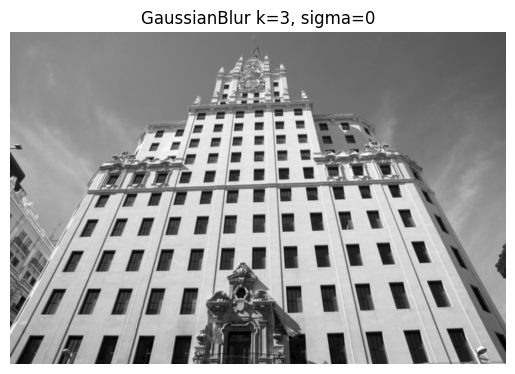

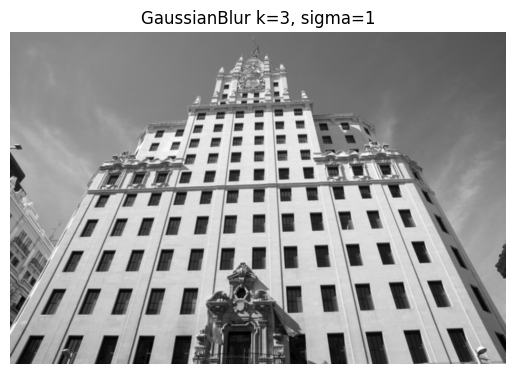

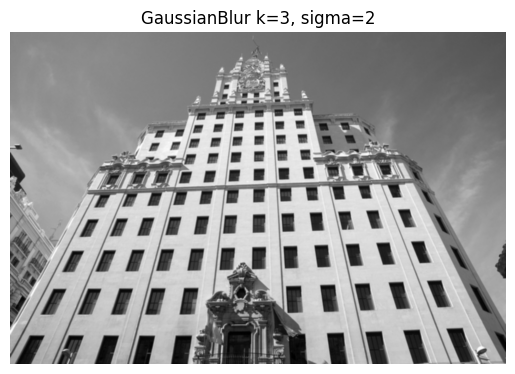

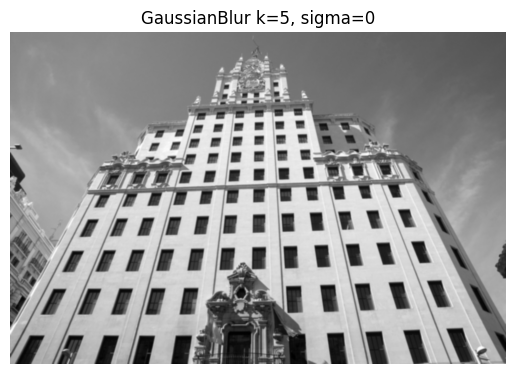

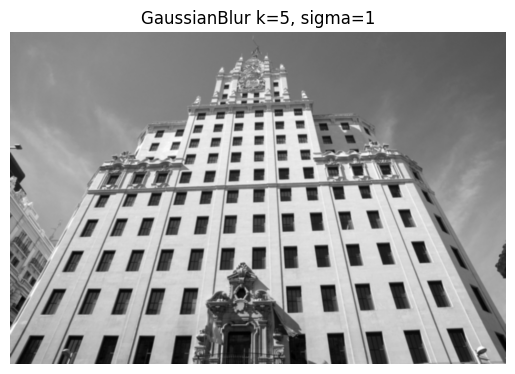

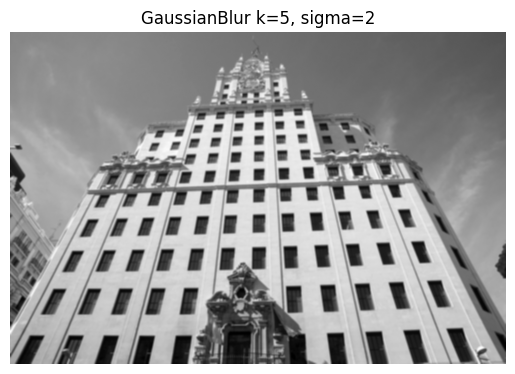

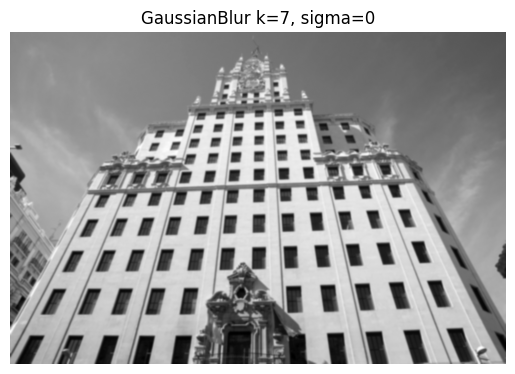

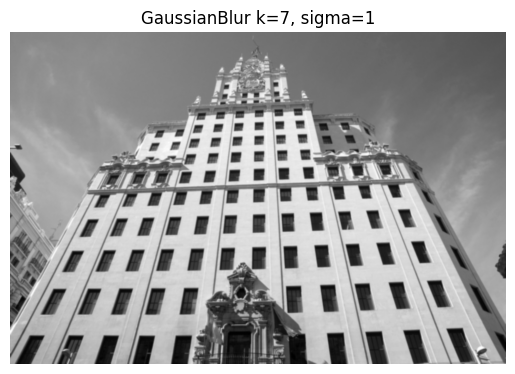

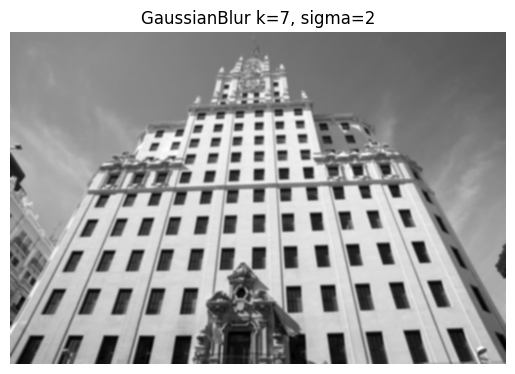

In [58]:
img = cv2.imread('img_pi/telefonica.jpg', cv2.IMREAD_GRAYSCALE)


kernel_sizes = [3, 5, 7]
sigma_values = [0, 1, 2]  # 0 deja que OpenCV calcule sigma automáticamente

for ksize in kernel_sizes:
    for sigma in sigma_values:
        img_blur = cv2.GaussianBlur(img, (ksize, ksize), sigma)
        plt.imshow(img_blur, cmap='gray')
        plt.title(f"GaussianBlur k={ksize}, sigma={sigma}")
        plt.axis('off')
        plt.show()


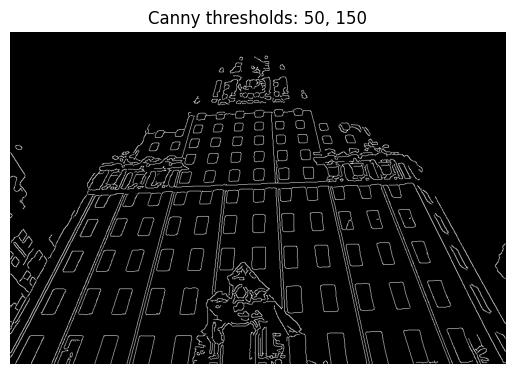

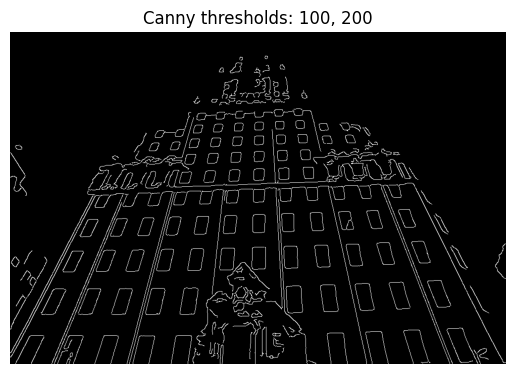

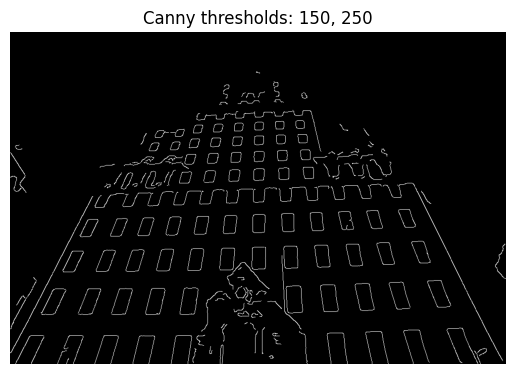

In [59]:
thresholds = [(50, 150), (100, 200), (150, 250)]

for t1, t2 in thresholds:
    edges = cv2.Canny(img_blur, threshold1=t1, threshold2=t2)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Canny thresholds: {t1}, {t2}")
    plt.axis('off')
    plt.show()


El filtro gaussiano suaviza la imagen antes de aplicar Canny. Con un sigma pequeño, se conservan todos los detalles y bordes finos, pero también se mantiene el ruido. Con un sigma grande, la imagen se suaviza mucho y solo se detectan los bordes principales, perdiéndose detalles pequeños. Esto es igual que lo que se vio en el Ejercicio 2 con la imagen de rejilla: el gaussiano suaviza más que el filtro tipo caja y mantiene los bordes de manera más natural. En resumen, el suavizado gaussiano ayuda a controlar qué bordes queremos resaltar, dependiendo de cuánto detalle o ruido haya en la imagen.

**Ejercicio 7**: utiliza la función [``cv2.HoughLines``](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a) de OpenCV para encontrar líneas en la imagen con los bordes detectados en el ejercicio anterior.

Discute el funcionamiento para distintos valores de los parámetros de la función, así como de los filtros utilizados para extraer los bordes de la imagen. Pinta los resultados sobre la imagen (te proporcionamos algo de código por si fuese útil).

In [60]:
def draw_lines(img, lines, color=(0, 0, 255), thickness=2):
    """Dibuja un conjunto de líneas detectadas con la transformada de Hough de OpenCV."""
    canvas = img.copy()
    if lines is not None:
        for i in range(len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

            cv2.line(canvas, pt1, pt2, color, thickness, cv2.LINE_AA)

    return canvas

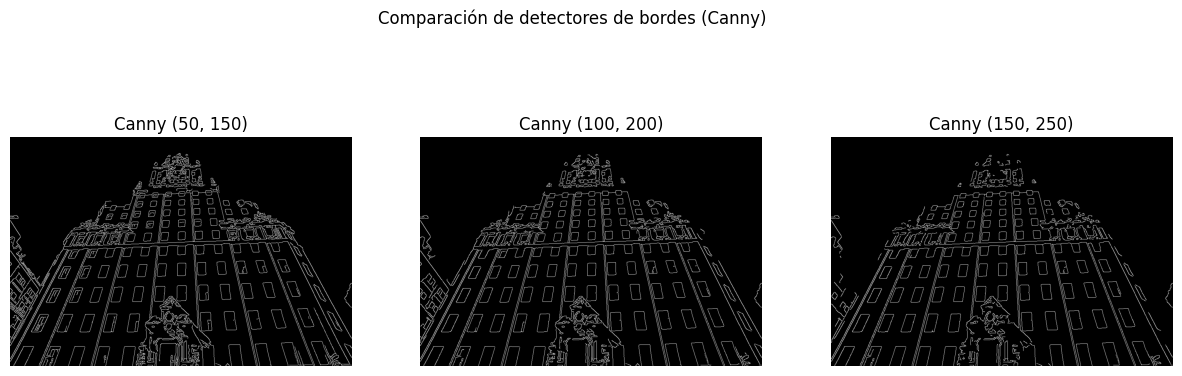

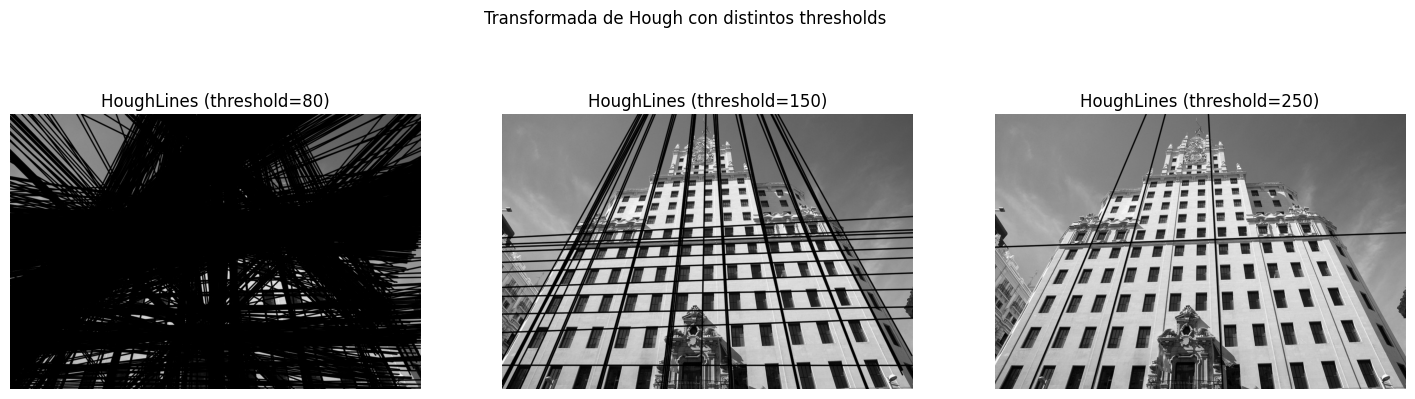

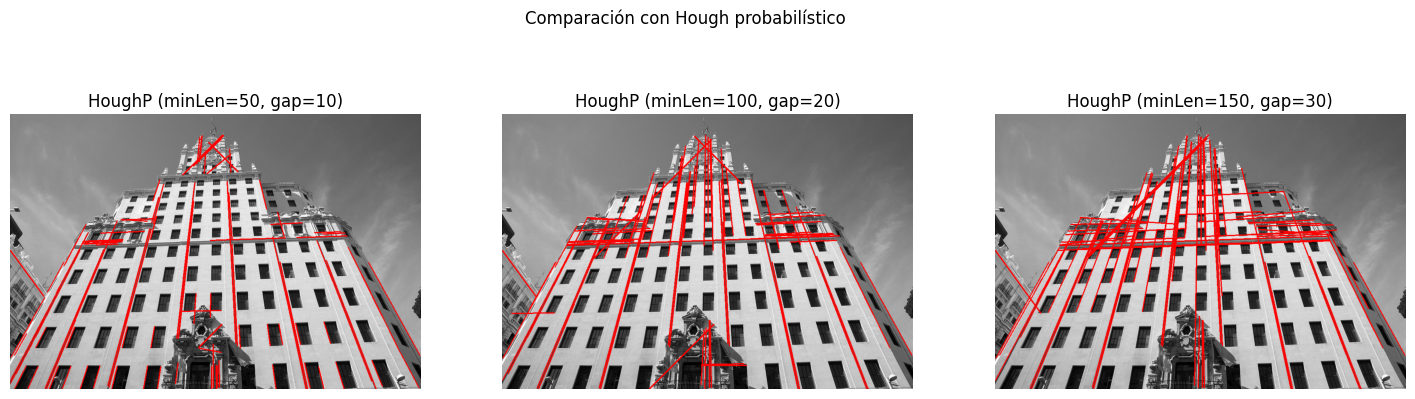

In [61]:
img = cv2.imread('img_pi/telefonica.jpg', cv2.IMREAD_GRAYSCALE)
blur = cv2.GaussianBlur(img, (5, 5), 1.5)


# 1COMPARACIÓN DE CANNY
canny_params = [(50, 150), (100, 200), (150, 250)]

plt.figure(figsize=(15, 5))
for i, (low, high) in enumerate(canny_params):
    edges = cv2.Canny(blur, low, high)
    plt.subplot(1, 3, i+1)
    plt.imshow(edges, cmap='gray')
    plt.title(f'Canny ({low}, {high})')
    plt.axis('off')
plt.suptitle("Comparación de detectores de bordes (Canny)")
plt.show()


# DIFERENTES THRESHOLDS HOUGH
edges = cv2.Canny(blur, 100, 200)

plt.figure(figsize=(18, 5))
for i, thr in enumerate([80, 150, 250]):
    lines = cv2.HoughLines(edges, 1, np.pi/180, thr)
    img_lines = draw_lines(img, lines)
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
    plt.title(f'HoughLines (threshold={thr})')
    plt.axis('off')
plt.suptitle("Transformada de Hough con distintos thresholds")
plt.show()


# COMPARACIÓN CON HOUGH PROBABILÍSTICO
params = [
    (50, 10),   # más segmentos cortos
    (100, 20),  # intermedio
    (150, 30)   # solo líneas largas y limpias
]

plt.figure(figsize=(18, 5))
for i, (minLen, maxGap) in enumerate(params):
    linesP = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80,
                             minLineLength=minLen, maxLineGap=maxGap)
    canvas = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if linesP is not None:
        for line in linesP:
            x1, y1, x2, y2 = line[0]
            cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 2)
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title(f'HoughP (minLen={minLen}, gap={maxGap})')
    plt.axis('off')
plt.suptitle("Comparación con Hough probabilístico")
plt.show()

- Parámetros bajos 

   - Detecta muchas líneas, incluso fragmentadas o falsas.

   - Útil para imágenes con bordes finos y poco ruido.

- Parámetros altos 

  - Detecta solo líneas claras y continuas.

  - Más robusto frente a ruido o texturas.

Influencia de los filtros previos

- Gaussiano: elimina ruido y suaviza bordes → líneas más continuas pero menos detalles finos.

- Mediana: elimina ruido impulsivo → líneas menos fragmentadas en bordes ruidosos.

- Bilateral: preserva bordes mientras elimina ruido → ideal para detectar líneas precisas en imágenes reales.